# TP02 - Regresión polinómica

In [93]:
#!pip install seaborn
#!pip install scikit-learn
#!curl -O https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/Fish.csv
#!curl -O https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/indicesforfish.json


# Exploración de datos

<p align="center">
  <image src="https://github.com/walteraguirre/TPS/blob/main/TP02/imagenes/ej1.png?raw=true" alt="Descripción de la imagen">
</p>

In [94]:
# Librerías estándar
import json
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos y transformaciones
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler

# Modelos
from sklearn.linear_model import LinearRegression, Ridge

# Evaluación de modelos
from sklearn.metrics import mean_squared_error

# Pipelines y configuración
from sklearn.pipeline import Pipeline
from sklearn import set_config



Para poder extraer la base de datos del archivo "Fish.csv" y poder facilitar su posterior manejo, vamos a utilizar la libreria pandas para poder extraer los datos en un dataframe.

Una variable aleatoria categórica, es aquella que puede tomar un número finito (o contable) de valores distintos, pero que estos valores representan categorías o etiquetas en lugar de cantidades númericas. En nuestro caso, la variable aleatoria categórica corresponde a las especies de pescados que aparecen en la base de datos, y que son 7 especies las cuales están explicitas en el enunciado.

Para poder obtener la proporcion de cada especie, se utiliza el método value_counts del dataframe de pandas y se normaliza. 

In [95]:
#Dataframe
df = pd.read_csv("Fish.csv")


# 1. Proporción de la variable categórica correspondiente a las especies
category_counts = df['Species'].value_counts(normalize=True)
print("Proporción de cada especie:")
print(category_counts)

Proporción de cada especie:
Species
Perch        0.352201
Bream        0.220126
Roach        0.125786
Pike         0.106918
Smelt        0.088050
Parkki       0.069182
Whitefish    0.037736
Name: proportion, dtype: float64


Al utilizar pairplot (de la libreria seaborn), generamos una matriz de gráficos de dispersion de todas las variables numéricas del dataframe. 

Cada punto representa una observación y su posición está dada por los valores de las dos variables en los ejes. El color de los puntos indica a que especie representa. 

En la diagonal principal, en lugar de gráficos de dispersión, se muestran gráficos de densidad para visualizar la distribución de cada variable numérica individualmente.

Estos gráficos nos permiten identificar si hay relaciones lineales o no entre las variables.

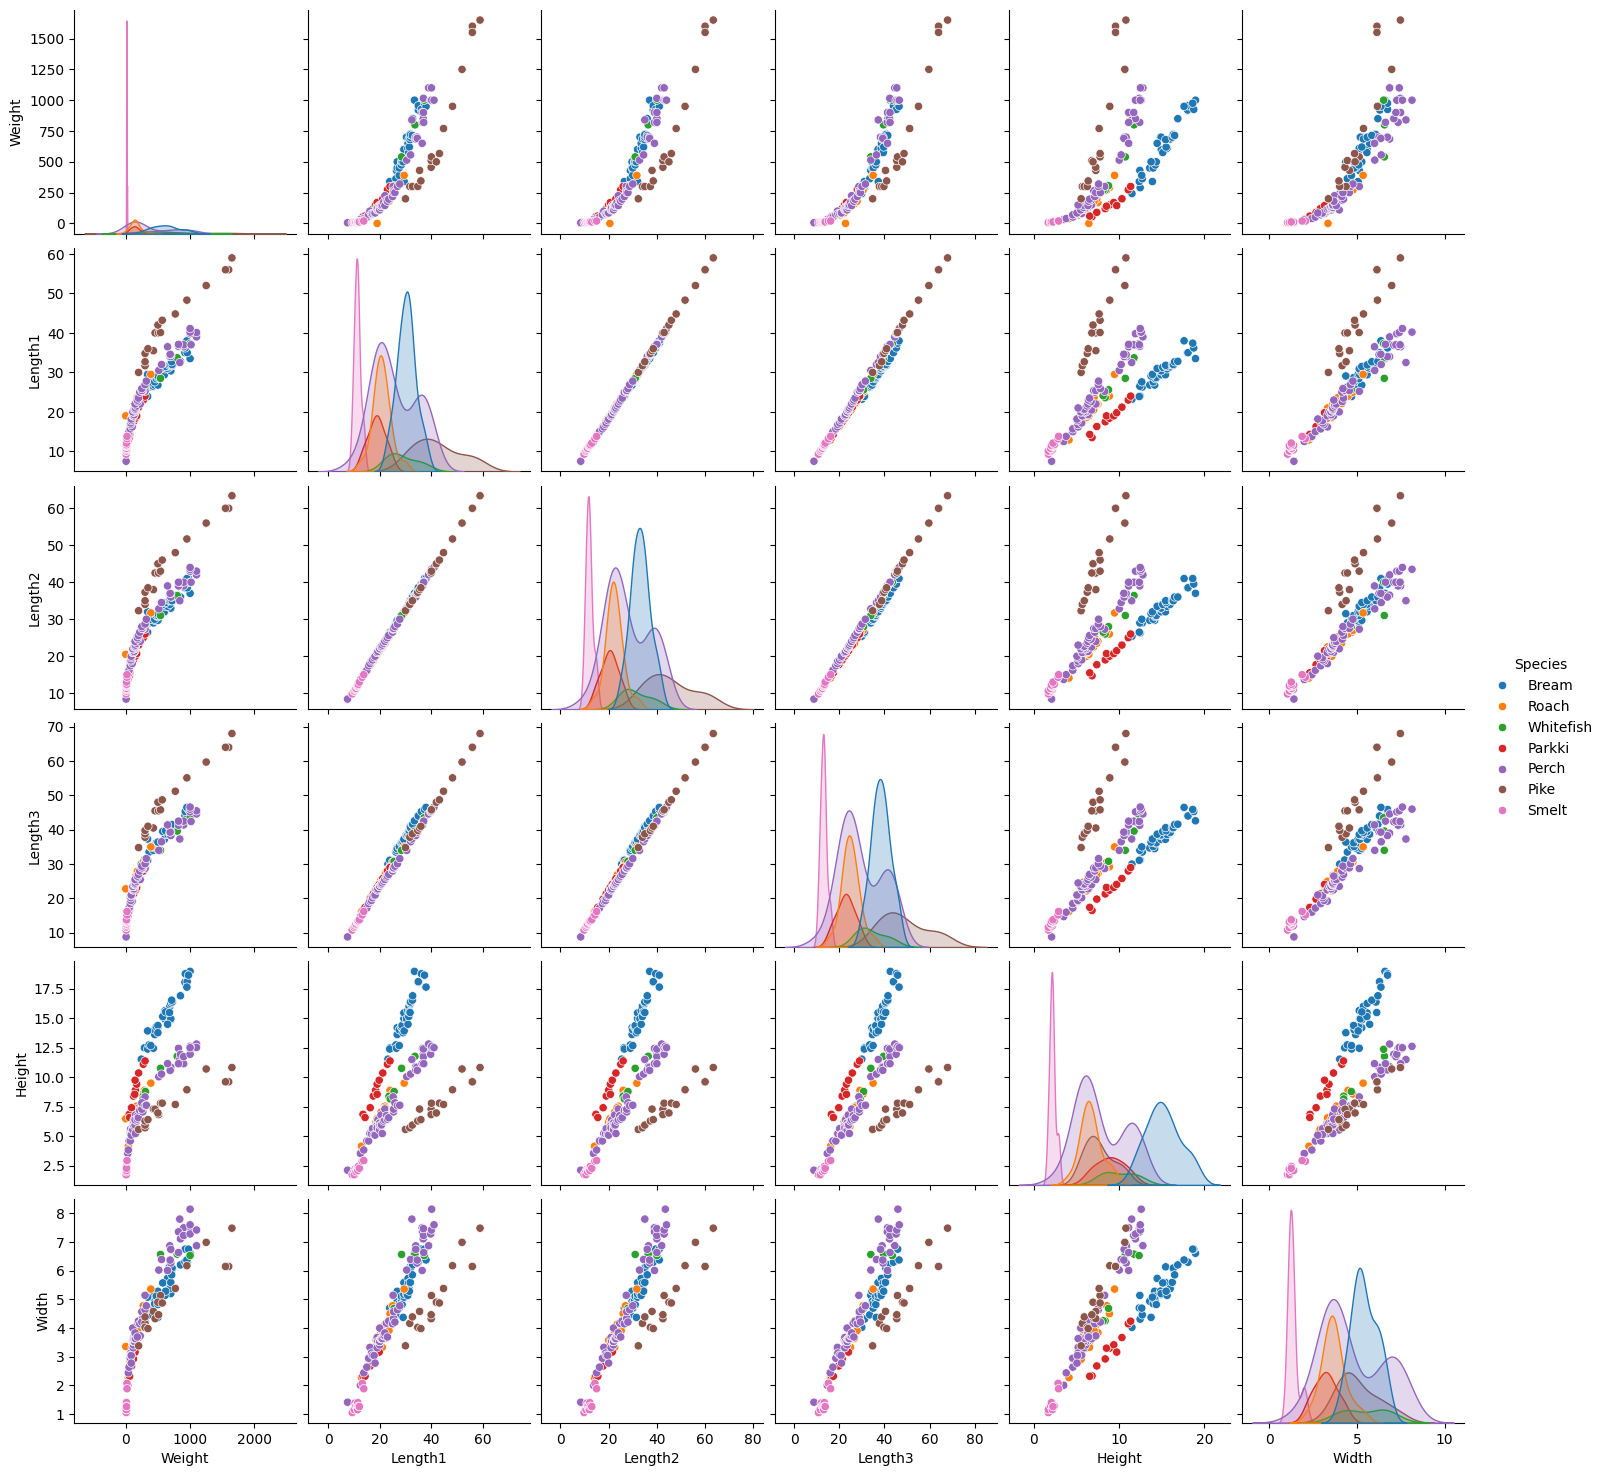

In [96]:
# 2. Pairplot de variables numéricas
sns.pairplot(df, hue='Species', diag_kind='kde')
plt.show()

Para poder extraer los indices, utilizamos la libreria json (ya que el archivo es .json)

In [97]:
#3. defino los conjuntos de entrenamiento, validacion y testeo

# obtengo los datos desde el archivo json
with open("indicesforfish.json", "r") as file:
    indices = json.load(file)

#separo los conjuntos

#conjunto de entrenamiento
train_indices = indices["train"]
X_train = df.iloc[train_indices]
y_train = df["Weight"].iloc[train_indices]

#conjunto de validacion
validation_indices = indices["validation"]
X_validation = df.iloc[validation_indices]
y_validation = df["Weight"].iloc[validation_indices]

#conjunto de testeo
test_indices = indices["test"]
X_test = df.iloc[test_indices]
y_test = df["Weight"].iloc[test_indices]

#verifico con las 5 primeras filas del conjunto de validacion 
print(X_validation.head())


   Species  Weight  Length1  Length2  Length3   Height   Width
97   Perch   145.0     22.0     24.0     25.5   6.3750  3.8250
61  Parkki    55.0     13.5     14.7     16.5   6.8475  2.3265
37   Roach    78.0     17.5     18.8     21.2   5.5756  2.9044
94   Perch   150.0     21.0     23.0     24.5   5.2185  3.6260
2    Bream   340.0     23.9     26.5     31.1  12.3778  4.6961


# Pre procesamiento

<p align="center">
  <image src="https://github.com/walteraguirre/TPS/blob/main/TP02/imagenes/ej2.png?raw=true" alt="Descripción de la imagen">
</p>

## One-Hot Encoding (OHE)

El One-hot Encoding lo que hace es transformar variables categóricas en un formato numérico adecuado para luego poder utilizar dichos datos en modelos de aprendizaje automático. Se crea una columna binaria (0 o 1) para cada categoría presente en la variable original.

Por ejemplo, tomando las 3 primeras especies de pescados de la base de datos (Bream, Roam, Whitefish)

| Especie |
| ----- |
| Bream  |
| Roam  |
| Whitefish |

Aplicando One-Hot Encoding, obtenemos:

| Bream | Roam | Whitefish |
| ---- | ---- | ----- |
| 1    | 0    | 0     |
| 0    | 1    | 0     |
| 0    | 0    | 1     |

Cada fila tiene un vector binario indicando la presencia (`1`) o ausencia (`0`) de cada categoría.


In [98]:
#1. one-hot encoder

#declaramos una instancia del encoder
encoder = OneHotEncoder(drop=None, sparse_output=False)

# verificamos el comportamiento del encoder:

#aplicamos one hot encoding
categorical_features = ["Species"]
encoded_species = encoder.fit_transform(df[categorical_features])

#convertimos a dataframe con nombre de columnas 
encoded_species_df = pd.DataFrame(encoded_species, columns=encoder.get_feature_names_out(categorical_features))

#verificamos con las 3 primeras filas del dataframe
print(encoded_species_df.head())

   Species_Bream  Species_Parkki  Species_Perch  Species_Pike  Species_Roach  \
0            1.0             0.0            0.0           0.0            0.0   
1            1.0             0.0            0.0           0.0            0.0   
2            1.0             0.0            0.0           0.0            0.0   
3            1.0             0.0            0.0           0.0            0.0   
4            1.0             0.0            0.0           0.0            0.0   

   Species_Smelt  Species_Whitefish  
0            0.0                0.0  
1            0.0                0.0  
2            0.0                0.0  
3            0.0                0.0  
4            0.0                0.0  


## Mapa polinómico de orden 2

In [99]:
#2. Mapa polinomico de orden 2

# Seleccionamos las variables numéricas excepto "Weight" 
numeric_features = ["Length1", "Length2", "Length3", "Height", "Width"]

# definimos la transformacion polinomica de orden 2
poly = PolynomialFeatures(degree=2)

#verificamos el comportamiento de la transformacion
poly_features = poly.fit_transform(df[numeric_features])

# Convertimos a DataFrame con nombres de columnas
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(numeric_features))


print(poly_features_df.head())


     1  Length1  Length2  Length3   Height   Width  Length1^2  \
0  1.0     23.2     25.4     30.0  11.5200  4.0200     538.24   
1  1.0     24.0     26.3     31.2  12.4800  4.3056     576.00   
2  1.0     23.9     26.5     31.1  12.3778  4.6961     571.21   
3  1.0     26.3     29.0     33.5  12.7300  4.4555     691.69   
4  1.0     26.5     29.0     34.0  12.4440  5.1340     702.25   

   Length1 Length2  Length1 Length3  Length1 Height  ...  Length2^2  \
0           589.28           696.00       267.26400  ...     645.16   
1           631.20           748.80       299.52000  ...     691.69   
2           633.35           743.29       295.82942  ...     702.25   
3           762.70           881.05       334.79900  ...     841.00   
4           768.50           901.00       329.76600  ...     841.00   

   Length2 Length3  Length2 Height  Length2 Width  Length3^2  Length3 Height  \
0           762.00        292.6080      102.10800     900.00       345.60000   
1           820.56    

In [100]:
#3. para combinar las operaciones anteriores para el preprocesamiento de los datos utilizamos la libreria ColumnTransformer.

# Definir las columnas a normalizar
features = encoded_species_df.columns.tolist() + poly_features_df.columns.tolist()

# Creamos el preprocesador juntando el encoder (para las variables categoricas) y la transformacion polinomica (para las variables numericas)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),  # Codificación one-hot para las variables categóricas
        ('num', Pipeline([
            ('poly', poly),
            ('scaler', StandardScaler())
        ]), numeric_features)  # codificacion para las variables numéricas
    ]
)


#verificamos el funcionamiento del preprocesador
data_transformed = preprocessor.fit_transform(df)

data_transformed_df = pd.DataFrame(data_transformed, columns=features)

print(data_transformed_df.head())




   Species_Bream  Species_Parkki  Species_Perch  Species_Pike  Species_Roach  \
0            1.0             0.0            0.0           0.0            0.0   
1            1.0             0.0            0.0           0.0            0.0   
2            1.0             0.0            0.0           0.0            0.0   
3            1.0             0.0            0.0           0.0            0.0   
4            1.0             0.0            0.0           0.0            0.0   

   Species_Smelt  Species_Whitefish    1   Length1   Length2  ...  Length2^2  \
0            0.0                0.0  0.0 -0.305789 -0.282303  ...  -0.401767   
1            0.0                0.0  0.0 -0.225507 -0.198054  ...  -0.334135   
2            0.0                0.0  0.0 -0.235542 -0.179332  ...  -0.318786   
3            0.0                0.0  0.0  0.005302  0.054694  ...  -0.117111   
4            0.0                0.0  0.0  0.025372  0.054694  ...  -0.117111   

   Length2 Length3  Length2 Height  Le

In [101]:
#esto es para comparar que pasa si normalizo tambien las variables categoricas

scaler = StandardScaler()

data_scaled = scaler.fit_transform(data_transformed)

data_scaled_df = pd.DataFrame(data_scaled, columns=features)

print(data_scaled_df.head())

   Species_Bream  Species_Parkki  Species_Perch  Species_Pike  Species_Roach  \
0       1.882248       -0.272625      -0.737353     -0.346003      -0.379322   
1       1.882248       -0.272625      -0.737353     -0.346003      -0.379322   
2       1.882248       -0.272625      -0.737353     -0.346003      -0.379322   
3       1.882248       -0.272625      -0.737353     -0.346003      -0.379322   
4       1.882248       -0.272625      -0.737353     -0.346003      -0.379322   

   Species_Smelt  Species_Whitefish    1   Length1   Length2  ...  Length2^2  \
0      -0.310728           -0.19803  0.0 -0.305789 -0.282303  ...  -0.401767   
1      -0.310728           -0.19803  0.0 -0.225507 -0.198054  ...  -0.334135   
2      -0.310728           -0.19803  0.0 -0.235542 -0.179332  ...  -0.318786   
3      -0.310728           -0.19803  0.0  0.005302  0.054694  ...  -0.117111   
4      -0.310728           -0.19803  0.0  0.025372  0.054694  ...  -0.117111   

   Length2 Length3  Length2 Height  Le

# Regresion lineal

<p align="center">
  <image src="https://github.com/walteraguirre/TPS/blob/main/TP02/imagenes/ej3.png?raw=true" alt="Descripción de la imagen">
</p>

In [102]:
#1. Creamos el pipeline para combinar el preprocesador con la regresión lineal 
pipeline = Pipeline([ 
    ('preprocessor', preprocessor),
    #('scaler', StandardScaler()),
    ('regressor', LinearRegression())  # Modelo de regresión lineal
])

# Configuramos la visualización del pipeline como diagrama
set_config(display="diagram")



In [103]:
# Convertimos y_train a un array 2D y normalizamos
y_train_reshaped = y_train.values.reshape(-1, 1) #y se corresponde con los pesos de los pescados
y_train_norm = scaler.fit_transform(y_train_reshaped)

#entrenamos el pipeline
pipeline.fit(X_train, y_train_norm)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Species']),
                                                 ('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Length1', 'Length2',
                                                   'Length3', 'Height',
                                                   'Width'])])),
                ('regressor', LinearRegression())])

In [104]:
#normalizo el conjunto de datos de validacion de y
y_validation_reshaped = y_validation.values.reshape(-1, 1) 
y_validation_norm = scaler.fit_transform(y_validation_reshaped)

#normalizao el conjunto de datos de testeo de y
y_test_reshaped = y_test.values.reshape(-1, 1)  
y_test_norm = scaler.fit_transform(y_test_reshaped)

# predicciones en el conjunto de entrenamiento
y_train_pred = pipeline.predict(X_train)

# predicciones en el conjunto de validación
y_val_pred = pipeline.predict(X_validation)

# predicciones en el conjunto de prueba
y_test_pred = pipeline.predict(X_test)

# Calculamos el Error Cuadrático Medio (MSE) en entrenamiento
mse_train = mean_squared_error(y_train_norm, y_train_pred)

# Calcular el Error Cuadrático Medio (MSE) en validación
mse_val = mean_squared_error(y_validation_norm, y_val_pred)

# Calcular el Error Cuadrático Medio (MSE) en prueba
mse_test = mean_squared_error(y_test_norm, y_test_pred)


# Reportar el RMSE para entrenamiento, validación y prueba
print(f'RMSE en el conjunto de entrenamiento: {mse_train}')
print(f'RMSE en el conjunto de validación: {mse_val}')
print(f'RMSE en el conjunto de prueba: {mse_test}')

RMSE en el conjunto de entrenamiento: 0.01471044021383154
RMSE en el conjunto de validación: 0.29400944301367227
RMSE en el conjunto de prueba: 0.29977239728981375


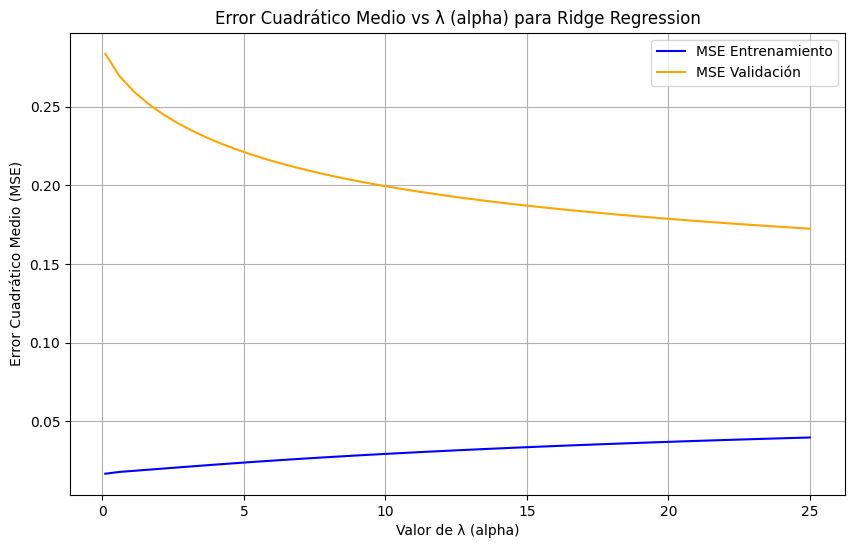

El mejor valor de alpha es: 25.0
El MSE en el conjunto de prueba con el mejor alpha es: 0.23284259567241078


In [105]:
# Crear el pipeline con el preprocesamiento y la regresión Ridge

# Definir el rango de valores de alpha a probar
alphas = np.linspace(0.1, 25, 50)

# Listas para almacenar los resultados de MSE
mse_train = []
mse_val = []
mse_test = []

#defino el pipeline
pipeline = Pipeline([ 
    ('preprocessor', preprocessor),
    #('scaler', StandardScaler()),
    ('regressor', Ridge())  # Puedes ajustar alpha entre 0 < α < 25
])

# Iterar sobre los diferentes valores de λ (alpha)
for alpha in alphas:

    #defino el alpha
    pipeline.set_params(regressor__alpha = alpha)

    # Ajustar el pipeline a los datos de entrenamiento
    pipeline.fit(X_train, y_train_norm)

    # Hacer predicciones en los tres conjuntos de datos
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_validation)
    y_test_pred = pipeline.predict(X_test)

    # Calcular el MSE para cada conjunto
    mse_train.append(mean_squared_error(y_train_norm, y_train_pred))
    mse_val.append(mean_squared_error(y_validation_norm, y_val_pred))
    mse_test.append(mean_squared_error(y_test_norm, y_test_pred))

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_train, label='MSE Entrenamiento', color='blue')
plt.plot(alphas, mse_val, label='MSE Validación', color='orange')
plt.xlabel('Valor de λ (alpha)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Error Cuadrático Medio vs λ (alpha) para Ridge Regression')
plt.legend()
plt.grid(True)
plt.show()

# Encontrar el mejor valor de alpha que minimiza el MSE de validación
best_alpha = alphas[np.argmin(mse_val)]
print(f"El mejor valor de alpha es: {best_alpha}")

# Evaluar el modelo con el mejor alpha en el conjunto de prueba
best_model = pipeline.set_params(regressor__alpha=best_alpha)
best_model.fit(X_train, y_train_norm)
y_test_pred = best_model.predict(X_test)
mse_test_best_alpha = mean_squared_error(y_test_norm, y_test_pred)
print(f"El MSE en el conjunto de prueba con el mejor alpha es: {mse_test_best_alpha}")